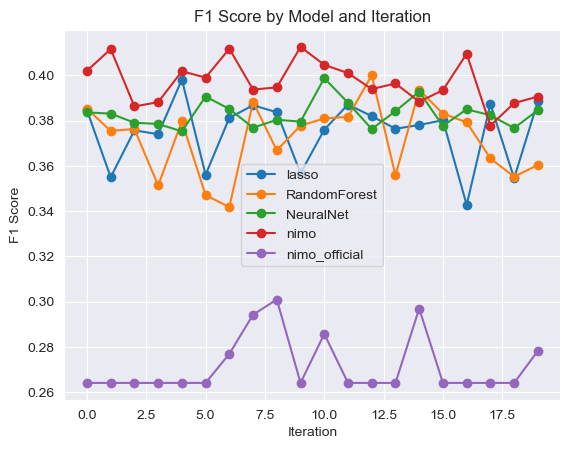

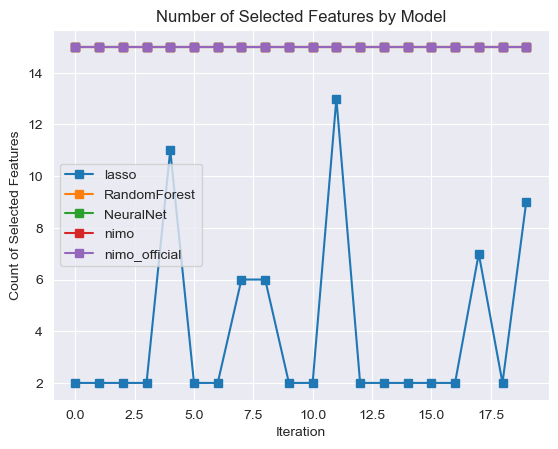

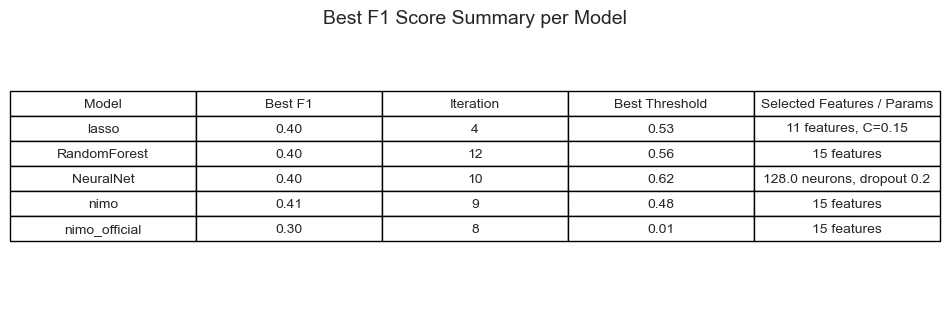

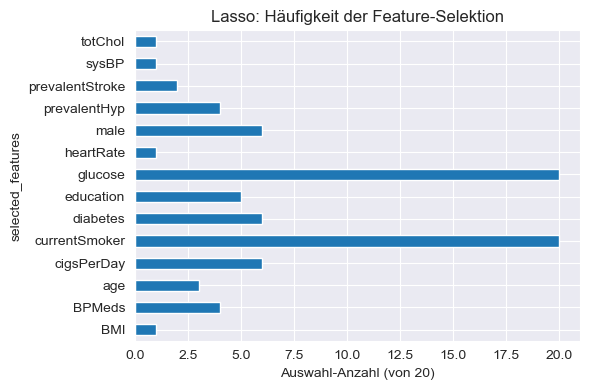

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

df = pd.read_csv("../results/all_model_results.csv")

df['y_pred'] = df['y_pred'].apply(ast.literal_eval)
df['y_prob'] = df['y_prob'].apply(ast.literal_eval)

df['selected_features'] = df['selected_features'].fillna('[]').apply(ast.literal_eval)

plt.figure()
for model in df['model_name'].unique():
    subset = df[df['model_name'] == model]
    plt.plot(subset['iteration'], subset['best_f1'], marker='o', label=model)
plt.title('F1 Score by Model and Iteration')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


df['n_selected_features'] = df['selected_features'].apply(len)
plt.figure()
for model in df['model_name'].unique():
    subset = df[df['model_name'] == model]
    plt.plot(subset['iteration'], subset['n_selected_features'], marker='s', label=model)
plt.title('Number of Selected Features by Model')
plt.xlabel('Iteration')
plt.ylabel('Count of Selected Features')
plt.legend()
plt.grid(True)
plt.show()


summary_rows = []
for model in df['model_name'].unique():
    best_row = df[df['model_name'] == model].sort_values(by='best_f1', ascending=False).iloc[0]
    summary_rows.append({
        'Model': best_row['model_name'],
        'Best F1': best_row['best_f1'],
        'Iteration': best_row['iteration'],
        'Best Threshold': best_row['best_threshold'],
        'Selected Features / Params': (
            f"{len(best_row['selected_features'])} features, C={best_row['lasso_C']}"
            if model == 'lasso' else
            f"{best_row.get('hidden_size', 'N/A')} neurons, dropout {best_row.get('dropout', 'N/A')}"
            if model == 'NeuralNet' else
            f"{len(best_row['selected_features'])} features"
)

    })



summary_df = pd.DataFrame(summary_rows)

formatted = summary_df.copy()
formatted['Best F1']        = formatted['Best F1'].map(lambda x: f"{x:.2f}")
formatted['Best Threshold'] = formatted['Best Threshold'].map(lambda x: f"{x:.2f}")

fig, ax = plt.subplots(figsize=(12, 1 + 0.5 * len(formatted)))
ax.axis('off')
table = ax.table(
    cellText=formatted.values,
    colLabels=formatted.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title("Best F1 Score Summary per Model", fontsize=14)
plt.show()




def parse_selected(x):
    # falls schon eine echte List, nichts tun
    if isinstance(x, list):
        return x
    # falls JSON-String (["glucose","currentSmoker"])
    if isinstance(x, str) and x.startswith('[') and '"' in x:
        return json.loads(x)
    # falls Python-repr als String ('['glucose','currentSmoker']')
    if isinstance(x, str):
        return ast.literal_eval(x)
    # sonst leer zurückgeben
    return []

df['selected_features'] = df['selected_features'].apply(parse_selected)

exploded = df[df['model_name']=='lasso'].explode('selected_features')
counts   = exploded['selected_features'].value_counts().sort_index()

counts.plot.barh(
    figsize=(6,4),
    xlabel='Auswahl-Anzahl (von 20)',
    title='Lasso: Häufigkeit der Feature-Selektion'
)
plt.tight_layout()
plt.show()